In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [3]:
!git clone https://github.com/jaysulk/PINO_Applications

fatal: destination path 'PINO_Applications' already exists and is not an empty directory.


In [4]:
%cd /content/drive/MyDrive/Github/PINO_Applications

/content/drive/MyDrive/Github/PINO_Applications


In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [6]:
!pip install functorch

In [7]:
!pip install Mat73

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import torch
# from torch import vmap
from functorch import vmap, grad

from models import FNN2d, FNN2d_AD
from train_utils import Adam
# from train_utils.datasets import BurgersLoader'
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import imageio

import torch.nn.functional as F

from tqdm import tqdm
from train_utils.utils import get_grid, save_checkpoint, torch2dgrid, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader1D
# from utils import torch2dgrid
from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None
import pickle

In [9]:
# Example usage with dummy Q function
def dummy_Q(a,b,T):
    return a*T + b

In [10]:
# Define the constants
w = 0.01
rho = 1.0   # Example value
p = 1000.0  # Example value
a = 1.0     # Linear coefficient for Q(T)
b = 0.0     # Constant term for Q(T)

def FDM_ThermodynamicEnergy(T, D=1, w=0.01, dt=0.1, dz=0.1, Q=None):
    batchsize = T.size(0)
    nt = T.size(1)
    nz = T.size(2)

    # Reshape T for convenience
    T = T.reshape(batchsize, nt, nz)

    # FFT of T to get the Fourier representation
    T_h = torch.fft.fft(T, dim=2)

    # Create wave numbers for FFT
    k_max = nz // 2
    k_z = torch.cat((torch.arange(start=0, end=k_max, step=1, device=T.device),
                     torch.arange(start=-k_max, end=0, step=1, device=T.device)), 0).reshape(1, 1, nz)

    # Calculate the Fourier representation of the spatial derivative dT/dz
    Tz_h = 2j * np.pi * k_z * T_h
    Tz = torch.fft.irfft(Tz_h[:, :, :k_max+1], dim=2, n=nz)

    # Use centered difference to calculate the temporal derivative dT/dt
    Tt = (T[:, 2:, :] - T[:, :-2, :]) / (2 * dt)

    # If Q is not specified, assume zero heating rate
    if Q is None:
        Q = torch.zeros_like(T)

    # Using the equation to determine change in T with respect to t
    DT = Tt + (-w * Tz + Q)[:, 1:-1, :]

    return DT

import torch
import torch.nn.functional as F

def PINO_loss_ThermodynamicEnergy(T, T0, w=0.01):
    batchsize = T.size(0)
    nt = T.size(1)
    nz = T.size(2)

    T = T.reshape(batchsize, nt, nz)

    # Setting up the boundary conditions in time (assuming initial conditions)
    index_t = torch.zeros(nz,).long()
    index_z = torch.tensor(range(nz)).long()
    boundary_T = T[:, index_t, index_z]

    # Loss between boundary temperature and initial temperature
    loss_T = F.mse_loss(boundary_T, T0)

    # Calculate residuals using the FDM_ThermodynamicEnergy function
    DT = FDM_ThermodynamicEnergy(T, w=w, Q=dummy_Q(0.5,0,T))  # Ensure FDM_ThermodynamicEnergy is defined

    # Residual loss
    f = torch.zeros_like(DT)
    loss_f = F.mse_loss(DT, f)

    # If you have boundary conditions in the z-direction for the thermodynamic energy equation,
    # you can uncomment and adjust the following lines. Otherwise, these are placeholders.
    # loss_bc0 = F.mse_loss(T[:, :, 0], T[:, :, -1])
    # loss_bc1 = F.mse_loss((T[:, :, 1] - T[:, :, -1]) / (2 / nz),
    #                       (T[:, :, 0] - T[:, :, -2]) / (2 / nz))

    return loss_T, loss_f

# Assume FDM_ThermodynamicEnergy is already defined and imported


In [11]:
class ThermodynamicsEq1D():
    def __init__(self, w=0.01, rho_over_p=1.0, a=0.5, b=0.0, xmin=0, xmax=1, Nx=100, nu=0.01, dt=1e-3, tend=1.0, device=None, dtype=torch.float64):
        self.xmin = xmin
        self.xmax = xmax
        self.Nx = Nx
        x = torch.linspace(xmin, xmax, Nx + 1, device=device, dtype=dtype)[:-1]
        self.x = x
        self.dx = x[1] - x[0]
        self.nu = nu
        self.u = torch.zeros_like(x, device=device)
        self.u0 = torch.zeros_like(self.u, device=device)
        self.dt = dt
        self.tend = tend
        self.t = 0
        self.it = 0
        self.U = []
        self.T = []
        self.device = device
        self.w = w
        self.rho_over_p = rho_over_p
        self.a = a
        self.b = b

    def CD_i(self, data, axis, dx):
        data_m2 = torch.roll(data,shifts=2,dims=axis)
        data_m1 = torch.roll(data,shifts=1,dims=axis)
        data_p1 = torch.roll(data,shifts=-1,dims=axis)
        data_p2 = torch.roll(data,shifts=-2,dims=axis)
        data_diff_i = (data_m2 - 8.0*data_m1 + 8.0*data_p1 - data_p2)/(12.0*dx)
        return data_diff_i

    def Dx(self, data):
        data_dx = self.CD_i(data=data, axis=0, dx=self.dx)
        return data_dx

    # Update Q function to be a linear function of T
    def Q_func(self, T):
        return self.a * T + self.b
        #return torch.zeros_like(T)

    def thermodynamics_calc_RHS(self, T):
        T_z = self.Dx(T)
        w_z = self.Dx(torch.full_like(T, self.w))
        T_RHS = -self.w * T_z + self.Q_func(T)
        return T_RHS

    def update_field(self, field, RHS, step_frac):
        field_new = field + self.dt*step_frac*RHS
        return field_new

    def rk4_merge_RHS(self, field, RHS1, RHS2, RHS3, RHS4):
        field_new = field + self.dt/6.0*(RHS1 + 2*RHS2 + 2.0*RHS3 + RHS4)
        return field_new

    def thermodynamics_rk4(self, T, t=0):
        T_RHS1 = self.thermodynamics_calc_RHS(T)
        t1 = t + 0.5*self.dt
        T1 = self.update_field(T, T_RHS1, step_frac=0.5)

        T_RHS2 = self.thermodynamics_calc_RHS(T1)
        t2 = t + 0.5*self.dt
        T2 = self.update_field(T, T_RHS2, step_frac=0.5)

        T_RHS3 = self.thermodynamics_calc_RHS(T2)
        t3 = t + self.dt
        T3 = self.update_field(T, T_RHS3, step_frac=1.0)

        T_RHS4 = self.thermodynamics_calc_RHS(T3)

        t_new = t + self.dt
        T_new = self.rk4_merge_RHS(T, T_RHS1, T_RHS2, T_RHS3, T_RHS4)

        return T_new, t_new

    def plot_data(self, cmap='jet', vmin=None, vmax=None, fig_num=0, title='', xlabel='', ylabel=''):
        plt.ion()
        fig = plt.figure(fig_num)
        plt.cla()
        plt.clf()
        plt.plot(self.x, self.u)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.draw()
        plt.pause(1e-17)
        plt.show()

    def thermodynamics_driver(self, T0, save_interval=10, plot_interval=0):
        self.u0 = T0[:self.Nx]
        self.u = self.u0
        self.t = 0
        self.it = 0
        self.T = []
        self.U = []

        if plot_interval != 0 and self.it % plot_interval == 0:
            self.plot_data(vmin=-1, vmax=1, title=r'\{T}')
        if save_interval != 0 and self.it % save_interval == 0:
            self.U.append(self.u)
            self.T.append(self.t)

        while self.t < self.tend:
            self.u, self.t = self.thermodynamics_rk4(self.u, self.t)
            self.it += 1
            if plot_interval != 0 and self.it % plot_interval == 0:
                self.plot_data(vmin=-1, vmax=1, title=r'\{T}')
            if save_interval != 0 and self.it % save_interval == 0:
                self.U.append(self.u)
                self.T.append(self.t)

        return torch.stack(self.U)


In [12]:
from tqdm import tqdm
# Make sure to import wandb, PINO_loss_ThermodynamicEnergy, LpLoss and other dependencies

def train_ThermodynamicEnergy(model,
                              train_loader,
                              optimizer,
                              scheduler,
                              config,
                              rank=0,
                              log=False,
                              project='PINO-2d-default',
                              group='default',
                              tags=['default'],
                              use_tqdm=True):
    if rank == 0 and log:
        import wandb  # Make sure wandb is installed
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    # Extract weights and other parameters from the config dictionary
    data_weight = config.get('train', {}).get('xy_loss', 1.0)
    f_weight = config.get('train', {}).get('f_loss', 1.0)
    ic_weight = config.get('train', {}).get('ic_loss', 1.0)
    nu = config.get('data', {}).get('nu', 0.01)
    ckpt_freq = config.get('train', {}).get('ckpt_freq', 10)

    model.train()
    myloss = LpLoss(size_average=True)  # Assuming LpLoss is defined

    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, loss_f = PINO_loss_ThermodynamicEnergy(out, x[:, 0, :, 0])
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()

        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)

        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )

        if log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)

    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [13]:
import torch
import numpy as np
from tqdm import tqdm
# Make sure to import LpLoss, PINO_loss_ThermodynamicEnergy, etc.

def eval_ThermodynamicEnergy(model,
                             dataloader,
                             config,
                             device,
                             use_tqdm=True):
    model.eval()
    model.to(device)
    myloss = LpLoss(size_average=True)  # Assuming LpLoss is defined
    nu = config.get('data', {}).get('nu', 0.01)

    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []

    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_ThermodynamicEnergy(out, x[:, 0, :, 0])
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')


In [14]:
config_file = 'configs/custom/TDE-0000.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'TDE-0000',
  'total_num': 100,
  'n_train': 90,
  'n_test': 10,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 1.0,
  'f_loss': 1.0,
  'xy_loss': 1.0,
  'save_dir': 'TDE',
  'save_name': 'TDE-0000.pt',
  'ckpt': 'checkpoints/TDE/TDE-0000.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-TDE', 'group': 'TDE-0000'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/TDE/TDE-0000.pt'}}

In [15]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
nu = config['data']['nu']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.1
L = 1.0
sigma = 1 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
Nu

In [17]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
#U0 = grf.sample(Nsamples)
#with open('U0.pkl', 'wb') as f:
#  pickle.dump(U0, f)

In [42]:
# Save the object to a file
with open('../../T0.pkl', 'rb') as f:
  U0 = pickle.load(f)

In [43]:
U0.shape

torch.Size([100, 128])

In [44]:
nu

0.01

In [45]:
TD_eq = ThermodynamicsEq1D(Nx=Nx, dt=dt, device=device)
save_interval = int(1e-2/dt)
U = vmap(TD_eq.thermodynamics_driver, in_dims=(0, None))(U0, save_interval)

In [46]:
a = U0.cpu().float()
u = U.cpu().float()
display(u.shape,a.shape)

torch.Size([100, 101, 128])

torch.Size([100, 128])

In [47]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [48]:
model = FNN2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              activation=config['model']['activation'],
             ).to(device)

In [49]:
log = False

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

In [50]:
#load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)

In [51]:
train_ThermodynamicEnergy(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 0, train loss: 1.10802 train f error: 0.00057; data l2 error: 1.08374:   0%|          | 1/500 [00:00<03:27,  2.41it/s]

Checkpoint is saved at checkpoints/TDE/TDE-0000_0.pt


Epoch 100, train loss: 0.03466 train f error: 0.01164; data l2 error: 0.02281:  20%|██        | 101/500 [00:31<02:06,  3.16it/s]

Checkpoint is saved at checkpoints/TDE/TDE-0000_100.pt


Epoch 200, train loss: 0.01960 train f error: 0.01166; data l2 error: 0.00793:  40%|████      | 201/500 [01:02<01:34,  3.16it/s]

Checkpoint is saved at checkpoints/TDE/TDE-0000_200.pt


Epoch 300, train loss: 0.01412 train f error: 0.01128; data l2 error: 0.00283:  60%|██████    | 301/500 [01:33<01:02,  3.20it/s]

Checkpoint is saved at checkpoints/TDE/TDE-0000_300.pt


Epoch 400, train loss: 0.01413 train f error: 0.01174; data l2 error: 0.00238:  80%|████████  | 401/500 [02:04<00:30,  3.20it/s]

Checkpoint is saved at checkpoints/TDE/TDE-0000_400.pt


Epoch 499, train loss: 0.01345 train f error: 0.01169; data l2 error: 0.00176: 100%|██████████| 500/500 [02:34<00:00,  3.23it/s]

Checkpoint is saved at checkpoints/TDE/TDE-0000.pt
Done!


In [52]:
eval_ThermodynamicEnergy(model, test_loader, config, device)

100%|██████████| 10/10 [00:00<00:00, 232.91it/s]

==Averaged relative L2 error mean: 0.00154973502503708, std error: 0.00015577218485595938==
==Averaged equation error mean: 0.01081842640414834, std error: 0.002335889883766539==


In [53]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [54]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [55]:
data_x.shape

torch.Size([1, 101, 128, 3])

In [56]:
use_train_data = False
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
# Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
Ntrain = config['data']['n_train']
loader = test_loader
if use_train_data:
    Ntest = Ntrain
    loader = train_loader
# in_dim = config['model']['in_dim']
# out_dim = config['model']['out_dim']

model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))


with torch.no_grad():
    for i, data in enumerate(loader):
#     for i, data in enumerate(train_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nt + padding, Nx)
#         out = out[..., :-padding, :]
#         pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding, out_dim)
        pred_y = pred_y_pad[..., :-padding, :].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
#         test_y0[i] = data_x[..., 0, -out_dim:].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [57]:
len(preds_y)

10

In [58]:
key = 0
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

(0.0, 1.0, 0.0, 1.0)

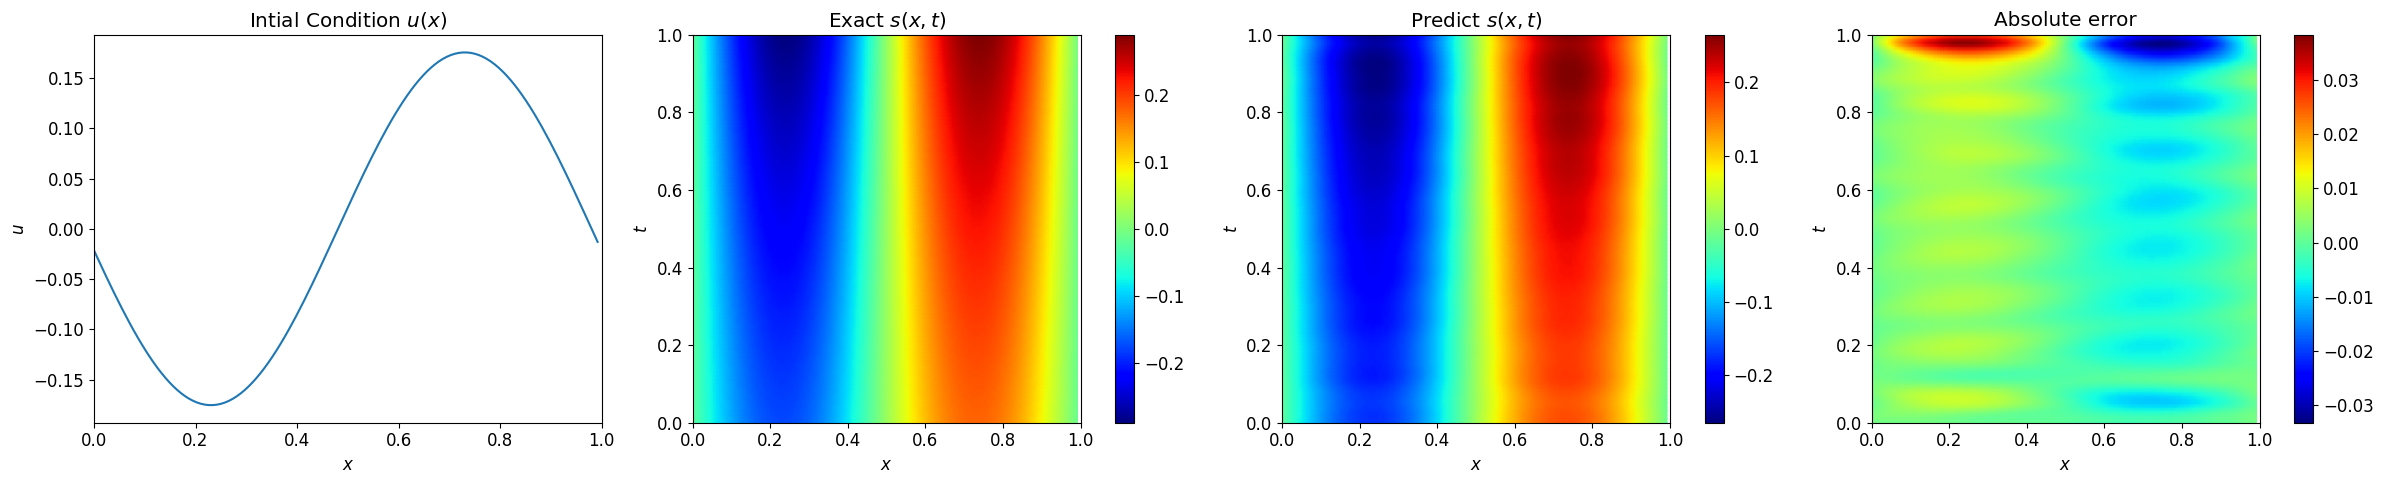

In [59]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $s(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $s(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

# plt.show()

In [60]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [61]:
data_dir = 'data/Burgers1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [62]:
save_data(data_path, test_x, test_y, preds_y)

In [63]:
test_x, test_y, preds_y = load_data(data_path)

In [64]:
def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))
    plt.subplot(1,4,1)

    plt.plot(x, u0)
    plt.xlabel('$z$')
    plt.ylabel('$T$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.ylim([-1,1])
    plt.tight_layout()

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
    cbar = plt.colorbar()
    #cbar.mappable.set_clim(-2, 2)
    plt.xlabel('$z$')
    plt.ylabel('$t$')
    plt.title(f'Exact $T(z,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
    cbar = plt.colorbar()
    #cbar.mappable.set_clim(-2, 2)
    plt.xlabel('$z$')
    plt.ylabel('$t$')
    plt.title(f'Predict $T(z,t)$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
    cbar = plt.colorbar()
    #cbar.mappable.set_clim(-0.2, 0.2)
    plt.xlabel('$z$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

In [65]:
%matplotlib inline
figures_dir = '../../TDE1D/FNO_LIN_Q/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'TDE1D_{key}')
    plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


Output hidden; open in https://colab.research.google.com to view.